In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题
np.random.seed(42)

In [2]:
def get_data():
    # 读取数据并处理数据
    path = "Z:\data\BTCUSDT\BTCUSDT-1h"
    filelist = os.listdir(path)
    filelist.sort()
    df = pd.DataFrame()
    for i in tqdm(filelist[-300:]):
        df0 = pd.read_csv(os.path.join(path, i))
        df = pd.concat([df, df0])
    df1 = df[['open_time', 'open', 'high', 'low', 'close', 'volume']]
    df1.columns = ['t', 'o', 'h', 'l', 'c', 'v']
    df1 = df1.dropna()
    return df1


# 1.首先读取数据
df = get_data()

100%|██████████| 300/300 [00:01<00:00, 167.90it/s]


In [3]:
def create_features(df):
    """
    创建用于预测的特征

    参数:
    df (pandas.DataFrame): 包含股票数据的DataFrame

    返回:
    pandas.DataFrame: 包含特征的DataFrame
    """
    df_feat = df.copy()

    # 创建滞后特征
    for i in range(1, 6):  # 1到5天的滞后
        if i == 1:  # 如果是当前时刻，就继续
            continue
        df_feat[f'lag_{i}'] = df_feat['c'].shift(i - 1)

    # 创建移动平均特征
    df_feat['MA_5'] = df_feat['c'].rolling(window=5).mean()
    df_feat['MA_10'] = df_feat['c'].rolling(window=10).mean()
    df_feat['MA_20'] = df_feat['c'].rolling(window=20).mean()

    # 创建波动率特征
    df_feat['Volatility_5'] = df_feat['c'].rolling(window=5).std()
    df_feat['Volatility_10'] = df_feat['c'].rolling(window=10).std()

    # 创建涨跌特征
    df_feat['Return'] = df_feat['c'].pct_change()
    df_feat['Return_prev'] = df_feat['Return'].shift(1)
    df_feat['Return_prev_2'] = df_feat['Return'].shift(2)

    # 创建价格变动特征
    df_feat['Price_change'] = df_feat['c'] - df_feat['o']
    df_feat['High_low'] = df_feat['h'] - df_feat['l']

    # RSI指标
    delta = df_feat['c'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df_feat['rsi'] = 100 - (100 / (1 + rs))

    # MACD指标
    df_feat['ema_12'] = df_feat['c'].ewm(span=12, adjust=False).mean()
    df_feat['ema_26'] = df_feat['c'].ewm(span=26, adjust=False).mean()
    df_feat['macd'] = df_feat['ema_12'] - df_feat['ema_26']
    df_feat['macd_signal'] = df_feat['macd'].ewm(span=9, adjust=False).mean()
    df_feat['macd_hist'] = df_feat['macd'] - df_feat['macd_signal']

    # 将当前时刻的c值，往前一段时间移动一位，即让未来时刻的数据作为当前时刻的预测目标
    df_feat['target'] = df['c'].shift(-1)

    # 删除包含NaN的行
    df_feat = df_feat.dropna()
    df_feat = df_feat.reset_index(drop=True)  # 修正：添加drop=True避免保留原索引

    return df_feat


# 2.对数据进行特征提取
df_feat = create_features(df=df)

In [4]:
# 3.去除掉索引值为index的列
df2 = df_feat.copy()

In [5]:
def split_data(df, target_col, test_size=0.2):
    """
    划分数据集为训练集和测试集

    参数:
    df (pandas.DataFrame): 包含特征和目标变量的DataFrame
    target_col (str): 目标变量列名
    test_size (float): 测试集比例，默认为0.2

    返回:
    tuple: 包含训练集特征、测试集特征、训练集目标、测试集目标的元组
    """
    # 确保不包含日期列
    X = df.drop([target_col, 't'], axis=1) if 't' in df.columns else df.drop([target_col], axis=1)
    y = df[target_col]

    # 转换为NumPy数组
    X = X.values
    y = y.values

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    return X_train, X_test, y_train, y_test


# 4.划分数据集
dates = pd.to_datetime(df2['t'], unit='ms')
X_train, X_test, y_train, y_test = split_data(df2, 'target', test_size=0.3)

In [6]:
# 保存特征名称用于特征重要性分析
feature_names = df2.drop(['target', 't'], axis=1).columns.tolist()

In [7]:
def standar(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled


# 5.对数据进行标准化
X_train_scaled, X_test_scaled = standar(X_train, X_test)  # 返回标准化后的数据

In [8]:
def train_lightgbm_model(train_data, test_data, X_test_scaled):
    """
    训练LightGBM模型并进行预测

    参数:
    train_data (lgb.Dataset): 训练数据集
    test_data (lgb.Dataset): 测试数据集
    X_test_scaled (numpy.ndarray): 标准化后的测试特征

    返回:
    tuple: 包含训练好的模型和预测结果的元组
    """
    # 设置模型参数
    params = {
        'objective': 'regression',  # 回归任务
        'metric': 'rmse',  # 评估指标为均方根误差
        'max_depth': 5,  # 树的最大深度
        'learning_rate': 0.1,  # 学习率
        'num_leaves': 31,  # 叶子节点数
        'feature_fraction': 0.8,  # 特征采样比例
        'bagging_fraction': 0.8,  # 样本采样比例
        'bagging_freq': 5,  # 样本采样频率
        'verbose': -1,  # 不输出信息
        'seed': 42  # 随机种子
    }

    # 添加早停机制
    early_stopping_rounds = 50

    # 训练模型
    model = lgb.train(
        params=params,
        train_set=train_data,
        num_boost_round=1000,
        valid_sets=[test_data],  # 只在验证集上评估
        valid_names=['validation']
    )

    # 使用标准化后的测试数据进行预测
    y_pred = model.predict(X_test_scaled, num_iteration=model.best_iteration)

    # 打印最佳迭代次数和验证集上的最佳分数
    print(f"Best iteration: {model.best_iteration}")
    print(f"Best score: {model.best_score['validation']['rmse']}")

    return model, y_pred


# 创建LightGBM数据集
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

# 6.训练LightGBM模型
model, y_pred = train_lightgbm_model(train_data, test_data, X_test_scaled)

Best iteration: 0
Best score: 113.82714116874905


In [9]:
true_number=0
false_number=0
predict_dict={'y_pred':y_pred,'y_test':y_test}
predict_dict_df=pd.DataFrame(predict_dict)
predict_dict_df['y_pred_diff']=predict_dict_df['y_pred'].shift(-1)-predict_dict_df['y_pred']
predict_dict_df['y_test_diff']=predict_dict_df['y_test'].shift(-1)-predict_dict_df['y_test']
predict_dict_df_dropna=predict_dict_df.dropna()
total_num=len(predict_dict_df)
for index,row in predict_dict_df_dropna.iterrows():
    pred_diff_sign = 1 if row['y_pred_diff'] > 0 else (-1 if row['y_pred_diff'] < 0 else 0)
    test_diff_sign = 1 if row['y_test_diff'] > 0 else (-1 if row['y_test_diff'] < 0 else 0)
    if pred_diff_sign == test_diff_sign:
        true_number += 1
    else:
        false_number += 1
Pon_accuracy=true_number/total_num*100
print(f"预测正确率为：{Pon_accuracy}%")
print(f"相同正负的数量: {true_number}")
print(f"不同正负的数量: {false_number}")

预测正确率为：47.307335190343544%
相同正负的数量: 1019
不同正负的数量: 1134


In [10]:
def evaluate_model(y_test, y_pred):
    """
    评估模型性能并返回各种评估指标

    参数:
    y_test (pandas.Series): 真实值
    y_pred (numpy.ndarray): 预测值

    返回:
    dict: 包含各种评估指标的字典
    """
    # 计算评估指标
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # 计算平均绝对百分比误差(MAPE)
    # 避免除零错误
    valid_indices = y_test != 0
    mape = np.mean(np.abs((y_test[valid_indices] - y_pred[valid_indices]) / y_test[valid_indices])) * 100

    # 创建评估指标字典
    metrics = {
        '均方误差(MSE)': mse,
        '均方根误差(RMSE)': rmse,
        '平均绝对误差(MAE)': mae,
        'R²分数(R2)': r2,
        '平均绝对百分比误差(MAPE)': mape
    }

    return metrics


# 7.评估模型的效果
metrics = evaluate_model(y_test, y_pred)
print("模型评估指标:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

模型评估指标:
均方误差(MSE): 12956.6196
均方根误差(RMSE): 113.8271
平均绝对误差(MAE): 72.5042
R²分数(R2): 0.9951
平均绝对百分比误差(MAPE): 0.2618


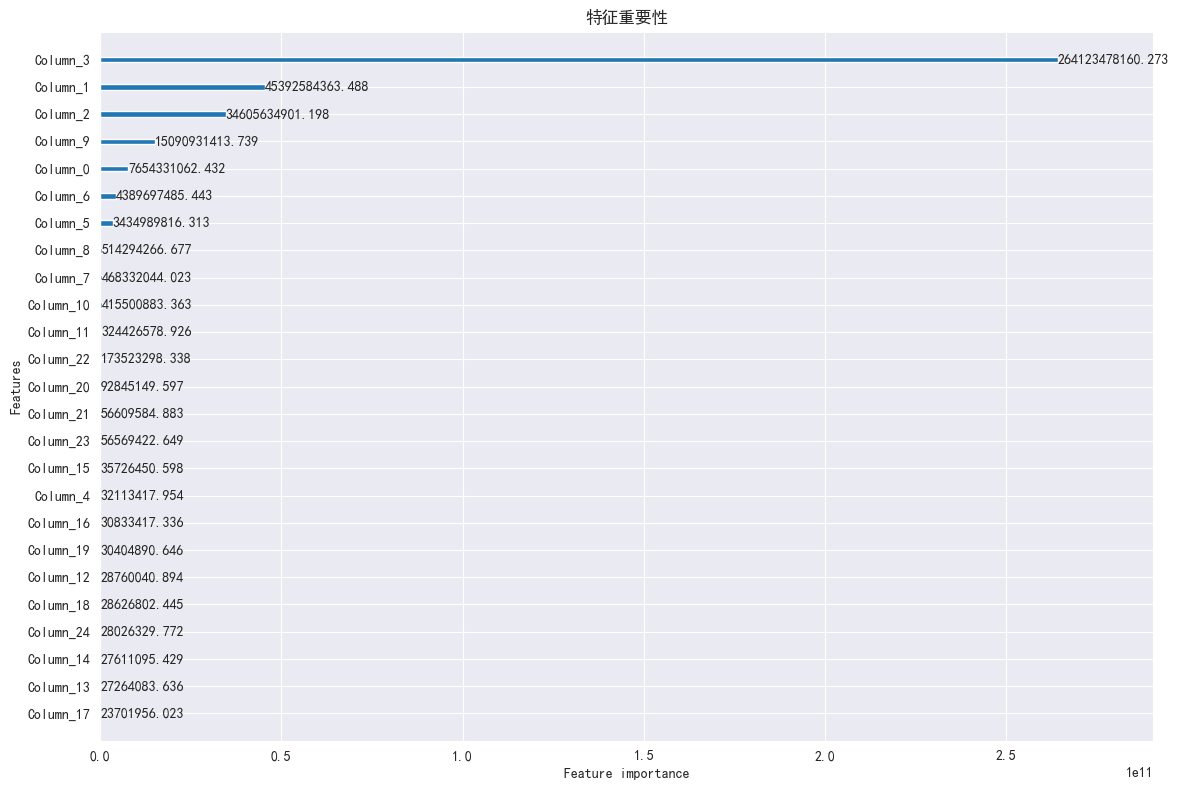

特征重要性:
          Feature    Importance
3               c  2.641235e+11
1               h  4.539258e+10
2               l  3.460563e+10
9            MA_5  1.509093e+10
0               o  7.654331e+09
6           lag_3  4.389697e+09
5           lag_2  3.434990e+09
8           lag_5  5.142943e+08
7           lag_4  4.683320e+08
10          MA_10  4.155009e+08
11          MA_20  3.244266e+08
22           macd  1.735233e+08
20         ema_12  9.284515e+07
21         ema_26  5.660958e+07
23    macd_signal  5.656942e+07
15    Return_prev  3.572645e+07
4               v  3.211342e+07
16  Return_prev_2  3.083342e+07
19            rsi  3.040489e+07
12   Volatility_5  2.876004e+07
18       High_low  2.862680e+07
24      macd_hist  2.802633e+07
14         Return  2.761110e+07
13  Volatility_10  2.726408e+07
17   Price_change  2.370196e+07


In [11]:
def plot_feature_importance(model, feature_names):
    """
    可视化特征重要性

    参数:
    model (lgb.Booster): 训练好的LightGBM模型
    feature_names (list): 特征名称列表
    """
    lgb.plot_importance(model, importance_type='gain', figsize=(12, 8))
    plt.title('特征重要性')
    plt.tight_layout()
    plt.show()

    # 打印特征重要性分数
    importance = model.feature_importance(importance_type='gain')
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    print("特征重要性:")
    print(feature_importance)


# 8.可视化特征重要性
plot_feature_importance(model, feature_names)

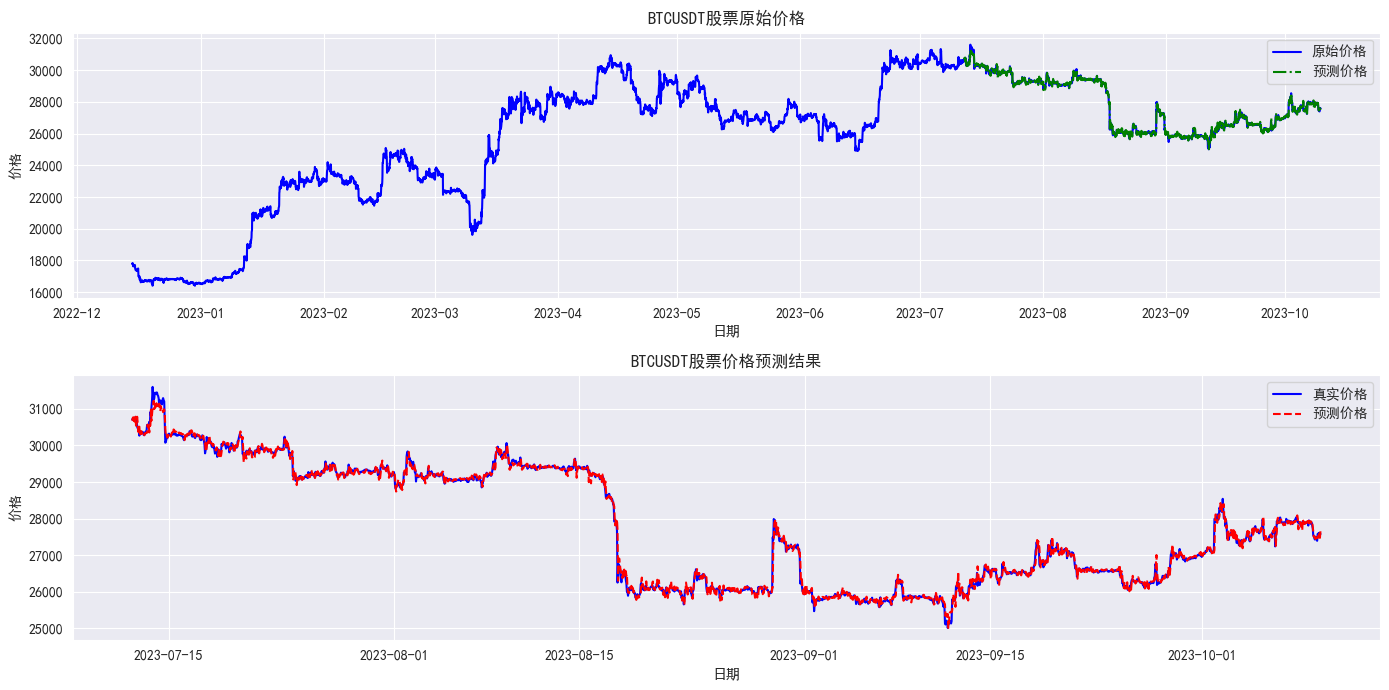

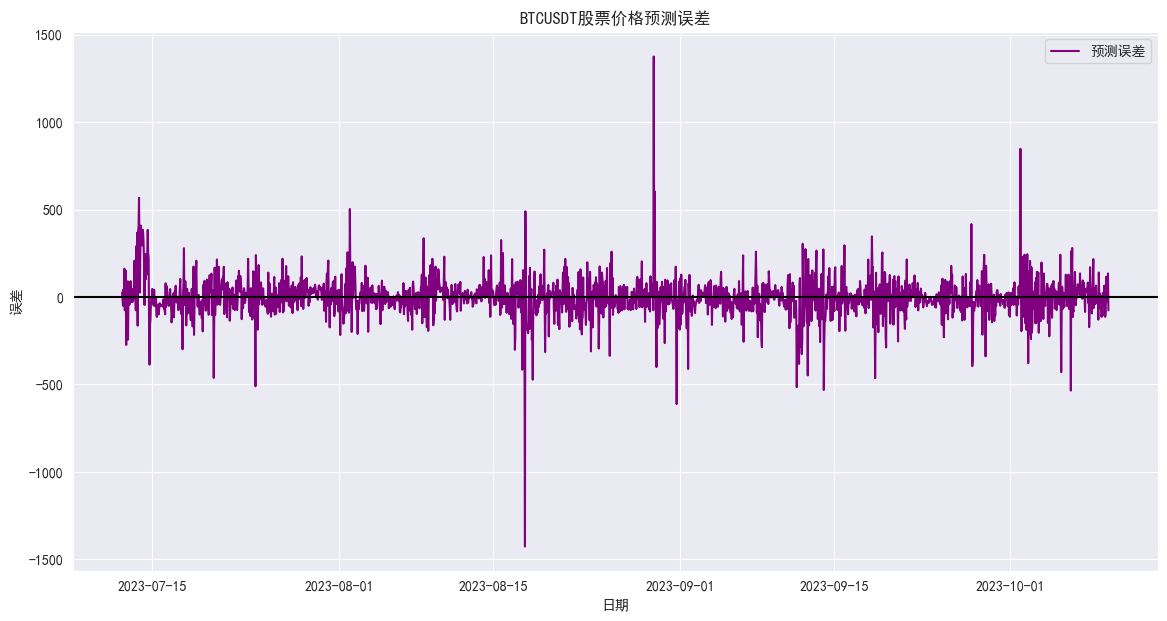

In [12]:
def visualize_results(df, y_test, y_pred, stock_code, train_size, dates):
    """
    可视化预测结果和真实结果

    参数:
    df (pandas.DataFrame): 原始数据集
    y_test (pandas.Series): 真实值
    y_pred (numpy.ndarray): 预测值
    stock_code (str): 股票代码
    train_size: 训练集的大小
    dates: 时间列表
    """
    # 创建预测结果DataFrame
    test_dates = dates[train_size + 1:]
    predictions_df = pd.DataFrame({'Date': test_dates, '真实价格': y_test[:-1], '预测价格': y_pred[:-1]})
    predictions_df.set_index('Date', inplace=True)

    # 可视化预测结果
    plt.figure(figsize=(14, 7))

    # 绘制原始价格曲线
    plt.subplot(2, 1, 1)
    plt.plot(dates, df['c'], label='原始价格', color='blue')
    plt.plot(dates[train_size + 1:], predictions_df['预测价格'], label='预测价格', color='green', linestyle='-.')
    plt.title(f'{stock_code}股票原始价格')
    plt.xlabel('日期')
    plt.ylabel('价格')
    plt.legend()
    plt.grid(True)

    # 绘制预测价格和真实价格对比
    plt.subplot(2, 1, 2)
    plt.plot(predictions_df.index, predictions_df['真实价格'], label='真实价格', color='blue')
    plt.plot(predictions_df.index, predictions_df['预测价格'], label='预测价格', color='red', linestyle='--')
    plt.title(f'{stock_code}股票价格预测结果')
    plt.xlabel('日期')
    plt.ylabel('价格')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # 绘制预测误差
    plt.figure(figsize=(14, 7))
    plt.plot(predictions_df.index, predictions_df['真实价格'] - predictions_df['预测价格'],
             label='预测误差', color='purple')
    plt.axhline(y=0, color='black', linestyle='-')
    plt.title(f'{stock_code}股票价格预测误差')
    plt.xlabel('日期')
    plt.ylabel('误差')
    plt.legend()
    plt.grid(True)
    plt.show()


# 9.呈现预测可视化的结果
train_size = len(y_train)
visualize_results(df2, y_test, y_pred, 'BTCUSDT', train_size=train_size, dates=dates)

In [13]:
# 接下来是做回测数据，首先用数据进行预测
df_predict = df_feat.iloc[train_size:, :]
x_predict = df_predict.drop('target', axis=1)
x_predict = x_predict.drop('t', axis=1)

# 对预测的特征进行标准化处理
scaler = StandardScaler()
x_predict_scaled = scaler.fit_transform(x_predict)

df_predict['target_predict'] = model.predict(X_test_scaled, num_iteration=model.best_iteration)
df_predict

,t,o,h,l,c,v,lag_2,lag_3,lag_4,lag_5,...,Price_change,High_low,rsi,ema_12,ema_26,macd,macd_signal,macd_hist,target,target_predict
5026,1689138000000,30623.9,30688.7,30600.0,30642.5,7630.501,30623.9,30581.3,30599.0,30518.9,...,18.6,88.7,54.277995,30573.633095,30525.800065,47.833030,45.601991,2.231039,30706.6,30680.615856
5027,1689141600000,30642.5,30786.0,30600.4,30706.6,17425.423,30642.5,30623.9,30581.3,30599.0,...,64.1,185.6,55.519860,30594.089542,30539.192653,54.896889,47.460971,7.435918,30730.8,30746.649864
5028,1689145200000,30706.6,30849.2,30699.0,30730.8,19690.812,30706.6,30642.5,30623.9,30581.3,...,24.2,150.2,62.853590,30615.121920,30553.385790,61.736130,50.316003,11.420128,30720.5,30770.493496
5029,1689148800000,30730.7,30750.6,30660.0,30720.5,11261.656,30730.8,30706.6,30642.5,30623.9,...,-10.2,90.6,73.540644,30631.333932,30565.764620,65.569312,53.366665,12.202648,30710.0,30666.851135
5030,1689152400000,30720.5,30748.8,30670.0,30710.0,5755.926,30720.5,30730.8,30706.6,30642.5,...,-10.5,78.8,65.826944,30643.436404,30576.448722,66.987682,56.090868,10.896814,30671.9,30664.111294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7175,1696874400000,27582.6,27739.6,27550.8,27554.9,25625.567,27582.6,27391.1,27433.0,27486.6,...,-27.7,188.8,31.619067,27563.001718,27668.305817,-105.304099,-94.975185,-10.328914,27607.6,27509.902170
7176,1696878000000,27555.0,27632.4,27526.3,27607.6,8683.886,27554.9,27582.6,27391.1,27433.0,...,52.6,106.1,37.439539,27569.862992,27663.809090,-93.946098,-94.769368,0.823270,27556.2,27585.401912
7177,1696881600000,27607.7,27644.0,27542.9,27556.2,4995.344,27607.6,27554.9,27582.6,27391.1,...,-51.5,101.1,32.991158,27567.760993,27655.838046,-88.077053,-93.430905,5.353852,27607.4,27472.462700
7178,1696885200000,27556.1,27627.2,27542.3,27607.4,3540.588,27556.2,27607.6,27554.9,27582.6,...,51.3,84.9,39.607926,27573.859302,27652.250043,-78.390741,-90.422872,12.032131,27575.9,27652.311737


In [14]:
df['c'][df['t'] == 1689141600000]

6    30706.6
Name: c, dtype: float64

In [15]:
# 对策略进行撰写
# 策略目标，和下一个target进行对比，如果下一个target比当前值高，我们就做满，下一个值比当前值低，我们就做空
def judge_get(df):
    df1 = df.copy()
    # 使用向量化操作根据条件赋值
    df1.loc[df1['target_predict'] > df1['target'], 'judge'] = 1  # 涨
    df1.loc[df1['target_predict'] < df1['target'], 'judge'] = -1  # 跌
    df1.loc[df1['target_predict'] == df1['target'], 'judge'] = 0  # 跌.loc[df1['target_shift'] == df1['target'], 'judge'] = 0  # 持平

    return df1[['t', 'c', 'judge']]


df_strategy = judge_get(df_predict)
df_strategy

,t,c,judge
5026,1689138000000,30642.5,-1.0
5027,1689141600000,30706.6,1.0
5028,1689145200000,30730.8,1.0
5029,1689148800000,30720.5,-1.0
5030,1689152400000,30710.0,-1.0
...,...,...,...
7175,1696874400000,27554.9,-1.0
7176,1696878000000,27607.6,1.0
7177,1696881600000,27556.2,-1.0
7178,1696885200000,27607.4,1.0


In [16]:
# 创建一个存储做空做满的列表
strategy_list = []  #[]
strategy_single_list = [0, 0, 0, 0]  # [t,oc,cc,judge]


def get_strategy(df):
    strategy = 0
    global strategy_single_list, strategy_list
    for row in df.itertuples():
        if row.judge == 1.0 and strategy == 0:
            strategy = 1
            strategy_single_list[0] = row.t
            strategy_single_list[1] = row.c
            strategy_single_list[3] = strategy
        if row.judge == -1.0 and strategy == 0:
            strategy = -1
            strategy_single_list[0] = row.t
            strategy_single_list[1] = row.c
            strategy_single_list[3] = strategy
        if strategy == 1 and row.judge == -1.0:  # 说明要进行盈亏了
            strategy_single_list[2] = row.c
            strategy_list.append(strategy_single_list.copy())
            strategy = -1
            strategy_single_list[0] = row.t
            strategy_single_list[1] = row.c
            strategy_single_list[3] = strategy
        if strategy == -1 and row.judge == 1.0:  # 说明要进行盈利亏了
            strategy_single_list[2] = row.c
            strategy_list.append(strategy_single_list.copy())
            strategy = 1
            strategy_single_list[0] = row.t
            strategy_single_list[1] = row.c
            strategy_single_list[3] = strategy


get_strategy(df_strategy)
strategy_list

[[1689138000000, 30642.5, 30706.6, -1],
 [1689141600000, 30706.6, 30720.5, 1],
 [1689148800000, 30720.5, 30765.3, -1],
 [1689159600000, 30765.3, 30709.3, 1],
 [1689163200000, 30709.3, 30725.4, -1],
 [1689170400000, 30725.4, 30474.1, 1],
 [1689177600000, 30474.1, 30508.5, -1],
 [1689184800000, 30508.5, 30268.1, 1],
 [1689188400000, 30268.1, 30338.3, -1],
 [1689195600000, 30338.3, 30368.9, 1],
 [1689202800000, 30368.9, 30328.1, -1],
 [1689213600000, 30328.1, 30283.7, 1],
 [1689217200000, 30283.7, 30284.5, -1],
 [1689220800000, 30284.5, 30308.1, 1],
 [1689224400000, 30308.1, 30560.2, -1],
 [1689238800000, 30560.2, 30560.1, 1],
 [1689242400000, 30560.1, 30530.6, -1],
 [1689246000000, 30530.6, 30501.3, 1],
 [1689249600000, 30501.3, 30915.4, -1],
 [1689260400000, 30915.4, 30814.9, 1],
 [1689264000000, 30814.9, 31285.7, -1],
 [1689314400000, 31285.7, 31096.0, 1],
 [1689318000000, 31096.0, 31205.6, -1],
 [1689350400000, 31205.6, 30208.0, 1],
 [1689372000000, 30208.0, 30323.0, -1],
 [1689382800

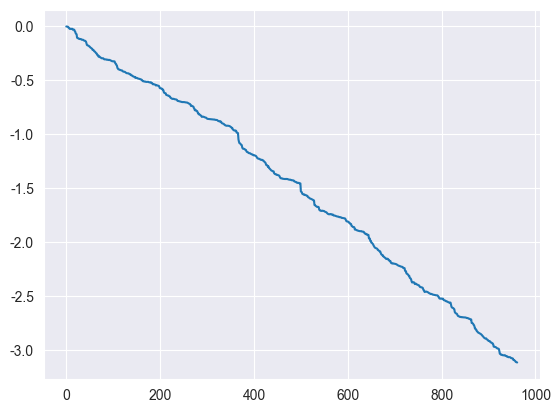

In [17]:
# 绘制收益曲线
trade_df = pd.DataFrame(strategy_list)
trade_df['profit'] = (trade_df[2] - trade_df[1]) / trade_df[1] * trade_df[3]
plt.plot(trade_df['profit'].cumsum())

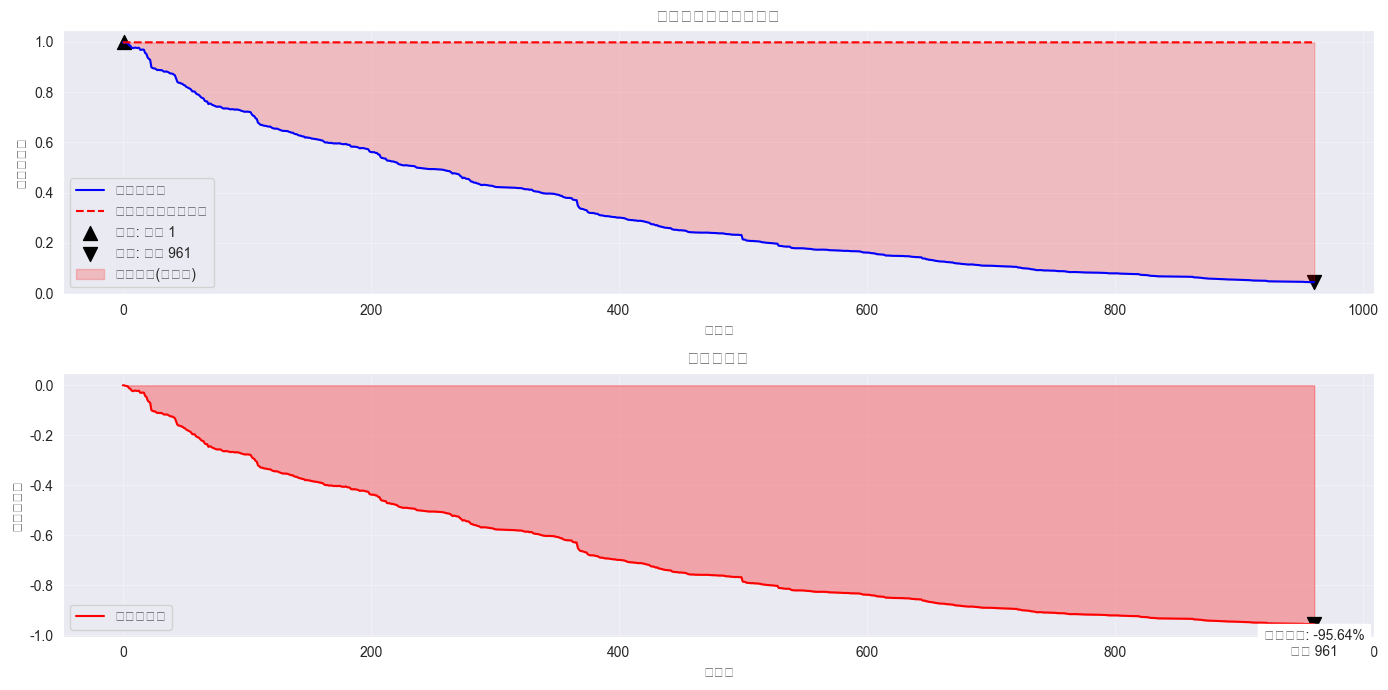

最大回撤: -95.64%
峰值位置: 索引 1
谷值位置: 索引 961
截至最新位置，回撤尚未恢复


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设你已经有一个名为trade_df的DataFrame，其中包含'profit'列
# 下面的代码将直接使用你的trade_df进行分析

# 计算累计收益率
trade_df['cumulative_return'] = (1 + trade_df['profit']).cumprod()

# 计算滚动最高值(用于最大回撤计算)
trade_df['rolling_max'] = trade_df['cumulative_return'].cummax()

# 计算回撤(当前值与历史最高值的差值)
trade_df['drawdown'] = trade_df['cumulative_return'] / trade_df['rolling_max'] - 1

# 计算最大回撤
max_drawdown = trade_df['drawdown'].min()
max_drawdown_idx = trade_df['drawdown'].idxmin()

# 计算从最高点到最低点的索引
peak_idx = trade_df.loc[:max_drawdown_idx, 'cumulative_return'].idxmax()
recovery_idx = None

# 寻找回撤恢复索引(如果有的话)
if max_drawdown < 0:
    post_drawdown_returns = trade_df.loc[max_drawdown_idx:, 'cumulative_return']
    if not post_drawdown_returns.empty:
        recovery_idx = \
            post_drawdown_returns[post_drawdown_returns >= trade_df['rolling_max'].loc[max_drawdown_idx]].index[
                0] if any(
                post_drawdown_returns >= trade_df['rolling_max'].loc[max_drawdown_idx]) else None

# 绘制最大收益率回测图
plt.figure(figsize=(14, 7))

# 绘制累计收益率曲线
plt.subplot(2, 1, 1)
plt.plot(trade_df['cumulative_return'], label='累计收益率', color='blue')
plt.plot(trade_df['rolling_max'], label='历史最高累计收益率', color='red', linestyle='--')

# 标记最大回撤的峰值和谷值
if max_drawdown < 0:
    plt.scatter(peak_idx, trade_df['cumulative_return'].loc[peak_idx],
                color='black', s=100, marker='^', label=f'峰值: 索引 {peak_idx}')
    plt.scatter(max_drawdown_idx, trade_df['cumulative_return'].loc[max_drawdown_idx],
                color='black', s=100, marker='v', label=f'谷值: 索引 {max_drawdown_idx}')

    # 如果有恢复索引，标记恢复点
    if recovery_idx:
        plt.scatter(recovery_idx, trade_df['cumulative_return'].loc[recovery_idx],
                    color='green', s=100, marker='o', label=f'恢复: 索引 {recovery_idx}')

        # 填充回撤区域
        plt.fill_between(
            trade_df.loc[peak_idx:recovery_idx].index,
            trade_df.loc[peak_idx:recovery_idx, 'cumulative_return'],
            trade_df.loc[peak_idx:recovery_idx, 'rolling_max'],
            color='red', alpha=0.2, label='回撤区域'
        )
    else:
        # 填充未恢复的回撤区域
        plt.fill_between(
            trade_df.loc[peak_idx:].index,
            trade_df.loc[peak_idx:, 'cumulative_return'],
            trade_df.loc[peak_idx:, 'rolling_max'],
            color='red', alpha=0.2, label='回撤区域(未恢复)'
        )

plt.title('累计收益率与最大回撤')
plt.xlabel('索引值')
plt.ylabel('累计收益率')
plt.legend()
plt.grid(True, alpha=0.3)

# 绘制回撤百分比图
plt.subplot(2, 1, 2)
plt.fill_between(trade_df.index, trade_df['drawdown'], 0,
                 where=trade_df['drawdown'] < 0, color='red', alpha=0.3)
plt.plot(trade_df.index, trade_df['drawdown'], color='red', label='回撤百分比')

# 标记最大回撤点
if max_drawdown < 0:
    plt.scatter(max_drawdown_idx, max_drawdown, color='black', s=100, marker='v')
    plt.text(max_drawdown_idx, max_drawdown - 0.02,
             f'最大回撤: {max_drawdown * 100:.2f}%\n索引 {max_drawdown_idx}',
             ha='center', va='top', backgroundcolor='white')

plt.title('回撤百分比')
plt.xlabel('索引值')
plt.ylabel('回撤百分比')
plt.ylim(bottom=min(trade_df['drawdown']) - 0.05, top=0.05)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 输出最大回撤信息
print(f"最大回撤: {max_drawdown * 100:.2f}%")
print(f"峰值位置: 索引 {peak_idx}")
print(f"谷值位置: 索引 {max_drawdown_idx}")

if recovery_idx:
    recovery_length = recovery_idx - peak_idx
    print(f"恢复位置: 索引 {recovery_idx}")
    print(f"回撤持续长度: {recovery_length}个周期")
else:
    print("截至最新位置，回撤尚未恢复")

In [19]:
# 先计算一天的收益率
trade_df['t'] = trade_df.iloc[:, 0] / 1000  # 将毫秒换算成秒
trade_df['t'] = (trade_df['t'] // (60 * 60 * 24))
profit_df=trade_df.groupby('t')['profit'].sum()
profit_df

t
19550.0   -0.022597
19551.0   -0.041132
19552.0   -0.045364
19553.0   -0.006378
19554.0   -0.013658
             ...   
19635.0   -0.046258
19636.0   -0.072020
19637.0   -0.010287
19638.0   -0.015773
19639.0   -0.045357
Name: profit, Length: 90, dtype: float64

In [20]:
# 计算夏普比率
def calculate_sharpe_ratio(trade_df, risk_free_rate=0.02, periods_per_year=252):
    """

    :param trade_df: 购买订单的信息
    :return:
    """
    # 计算平均收益率和标准差
    mean = trade_df['profit'].mean()
    std = trade_df['profit'].std()

    # 转换无风险利率
    daily_risk_free = (1 + risk_free_rate) ** (1 / periods_per_year) - 1

    return (mean - daily_risk_free) / std


trade_sharpe_ratio = calculate_sharpe_ratio(trade_df)
print(f"按天计算的夏普比率为: {trade_sharpe_ratio*100:.2f}%")

按天计算的夏普比率为: -61.20%
